In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
PATH = '/content/drive/MyDrive/duck_chick_dataset/Dataset/'

In [4]:

train_dir = os.path.join(PATH, 'Train')
validation_dir = os.path.join(PATH, 'Test')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)


Found 200 files belonging to 2 classes.


In [5]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)


Found 120 files belonging to 2 classes.


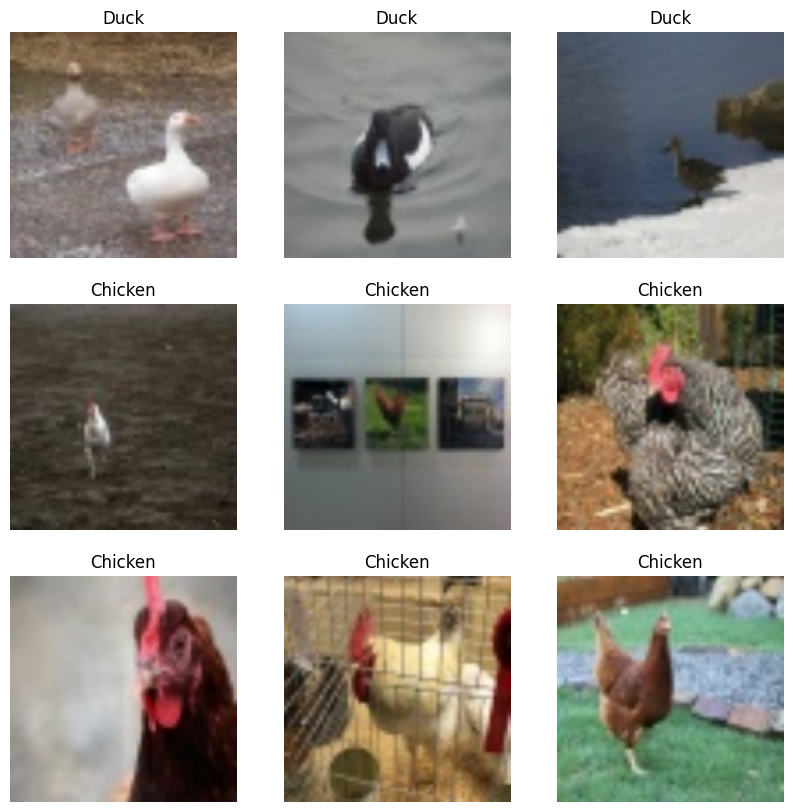

In [6]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [9]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 2)
validation_dataset = validation_dataset.skip(val_batches // 2)


In [10]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))


Number of validation batches: 2
Number of test batches: 2


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


In [12]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])


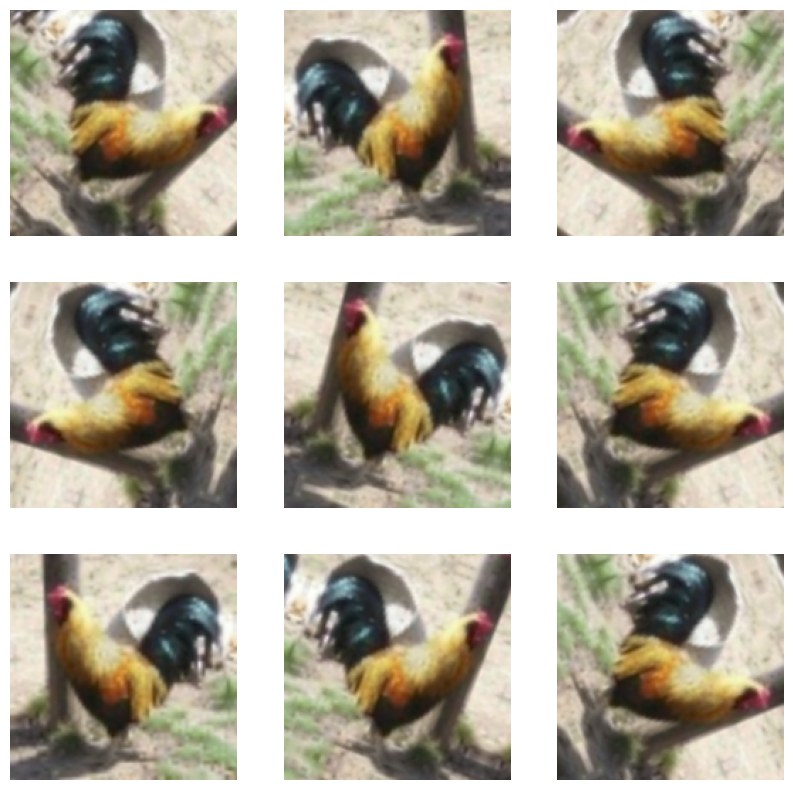

In [13]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


In [14]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


In [15]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)


In [16]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [17]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(32, 5, 5, 1280)


In [18]:
base_model.trainable = False

In [19]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [20]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


(32, 1280)


In [21]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [22]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


In [23]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [25]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)


2/2 [==============================] - 21s 672ms/step - loss: 0.8700 - accuracy: 0.4464


In [26]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


initial loss: 0.87
initial accuracy: 0.45


In [27]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)


Epoch 1/10
7/7 [==============================] - 13s 1s/step - loss: 0.9089 - accuracy: 0.4700 - val_loss: 0.7428 - val_accuracy: 0.5893
Epoch 2/10
7/7 [==============================] - 5s 730ms/step - loss: 0.8116 - accuracy: 0.5500 - val_loss: 0.8213 - val_accuracy: 0.5000
Epoch 3/10
7/7 [==============================] - 9s 1s/step - loss: 0.8151 - accuracy: 0.5050 - val_loss: 0.8040 - val_accuracy: 0.5357
Epoch 4/10
7/7 [==============================] - 7s 957ms/step - loss: 0.8476 - accuracy: 0.5150 - val_loss: 0.7808 - val_accuracy: 0.5357
Epoch 5/10
7/7 [==============================] - 6s 714ms/step - loss: 0.7798 - accuracy: 0.5200 - val_loss: 0.7421 - val_accuracy: 0.5714
Epoch 6/10
7/7 [==============================] - 5s 691ms/step - loss: 0.7874 - accuracy: 0.5100 - val_loss: 0.7112 - val_accuracy: 0.5714
Epoch 7/10
7/7 [==============================] - 10s 1s/step - loss: 0.7947 - accuracy: 0.5300 - val_loss: 0.7242 - val_accuracy: 0.5000
Epoch 8/10
7/7 [===========

In [28]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False


In [30]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])


In [31]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [32]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)


Epoch 10/20
7/7 [==============================] - 29s 3s/step - loss: 0.6239 - accuracy: 0.6700 - val_loss: 0.6174 - val_accuracy: 0.6786
Epoch 11/20
7/7 [==============================] - 11s 2s/step - loss: 0.5870 - accuracy: 0.6500 - val_loss: 0.5420 - val_accuracy: 0.7143
Epoch 12/20
7/7 [==============================] - 10s 1s/step - loss: 0.4804 - accuracy: 0.6950 - val_loss: 0.4670 - val_accuracy: 0.8214
Epoch 13/20
7/7 [==============================] - 14s 2s/step - loss: 0.4038 - accuracy: 0.8250 - val_loss: 0.4588 - val_accuracy: 0.7857
Epoch 14/20
7/7 [==============================] - 12s 2s/step - loss: 0.4434 - accuracy: 0.7650 - val_loss: 0.4404 - val_accuracy: 0.7500
Epoch 15/20
7/7 [==============================] - 10s 1s/step - loss: 0.3321 - accuracy: 0.8550 - val_loss: 0.4509 - val_accuracy: 0.7857
Epoch 16/20
7/7 [==============================] - 9s 1s/step - loss: 0.3314 - accuracy: 0.8400 - val_loss: 0.4256 - val_accuracy: 0.7500
Epoch 17/20
7/7 [===========

In [33]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)



2/2 [==============================] - 2s 1s/step - loss: 0.3385 - accuracy: 0.8281
Test accuracy : 0.828125


Predictions:
 [1 1 0 0 1 1 0 0 0 1 1 1 1 0 1 0 1 0 0 1 1 0 1 1 0 1 1 0 1 0 0 0]
Labels:
 [1 1 0 0 1 1 0 0 0 1 1 1 1 0 1 0 1 0 0 1 1 0 1 0 0 1 0 0 1 1 0 0]


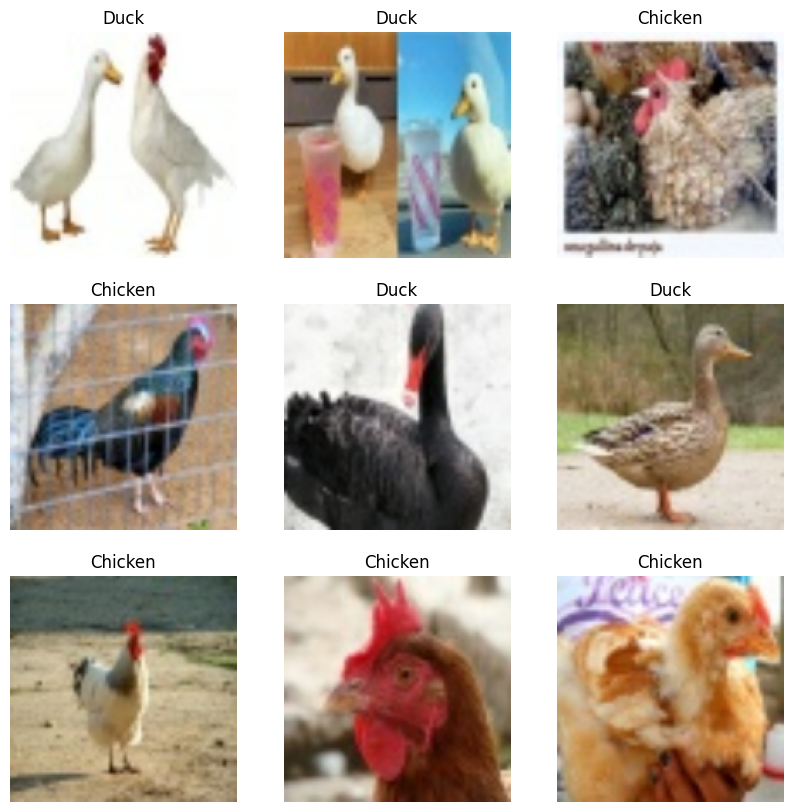

In [34]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")
